In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
from cmocean import cm
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='01:00:00')
w = cluster.scale(1*6)

/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.37.64:44539 Dashboard: http://10.135.37.64:33345/status,Cluster Workers: 6 Cores: 6 Memory: 100.02 GB


In [5]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [6]:
v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ageo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [7]:
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_ageo_zav.latitude))
f_cpd = f*86400/2./np.pi

In [8]:
df=E_ageo_zav.freq_time[1]-E_ageo_zav.freq_time[0]
E_ageo_zav_sum = (E_ageo_zav.where((abs(E_ageo_zav.freq_time)<12), other=0.)*df).sum(['freq_time'])
E_ageo_zav_cumsum = (E_ageo_zav.where((abs(E_ageo_zav.freq_time)<12), other=0.)*df).cumsum(['freq_time'])
E_ageo_zav_cumsum

<xarray.DataArray (freq_time: 1440, latitude: 119)>
dask.array<nancumsum, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

In [9]:
ratio = E_ageo_zav_cumsum/E_ageo_zav_sum
ratio

<xarray.DataArray (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

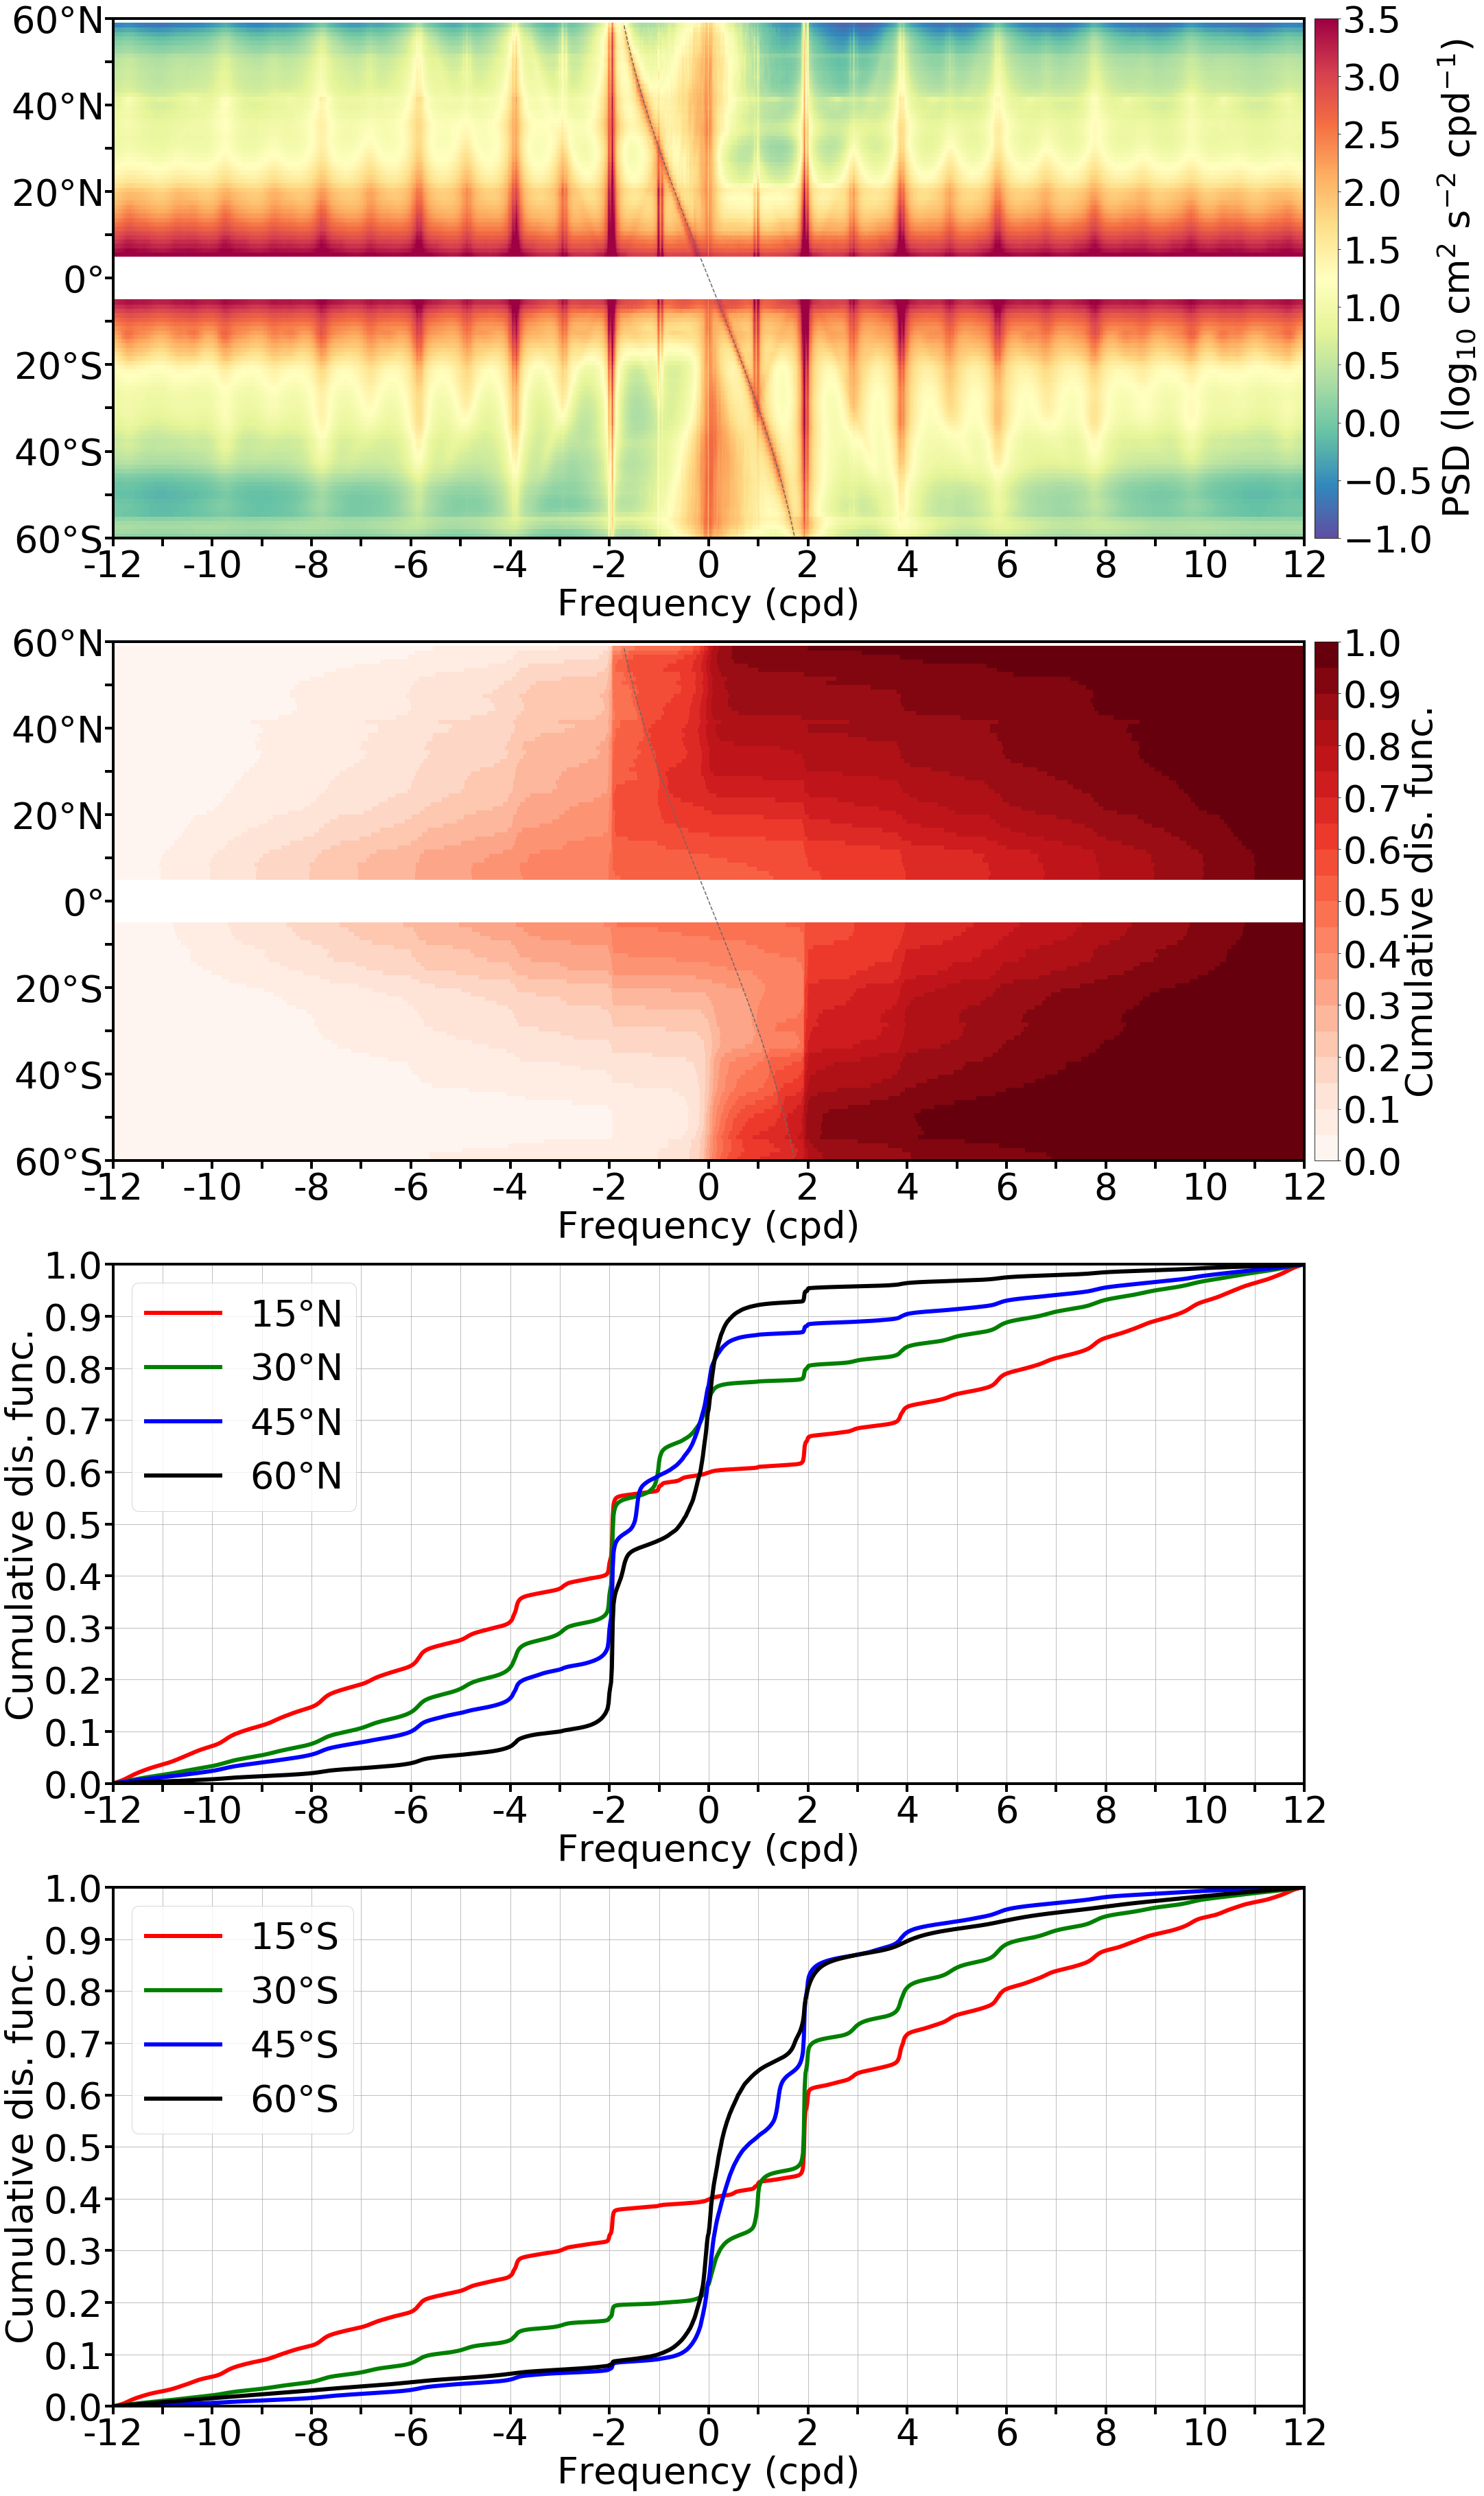

In [11]:
equator = 5
font_size = 54
linewidth = 6

fig, (ax1, ax2, ax3, ax4)  = plt.subplots(4,1,sharex=True,figsize=(32, 64))

ax1=plt.subplot(411)
im1=np.log10(E_ageo_zav.where(np.abs(E_ageo_zav.latitude)>equator)*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=.2)
cbar = plt.colorbar(im1,  cax=cax, orientation='vertical', ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax1.set_xlim(-12., 12.)
ax1.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax1.set_xticklabels(['-12','','-10','','-8','','-6','','-4','','-2','','0','','2','','4','','6','','8','','10','','12'])
ax1.set_ylim(-60., 60.)
ax1.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax1.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax1.tick_params(direction='out', length=6, width=2)
#ax1.set_title('$u_a + i v_a$',fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.set_ylabel('',fontsize=font_size)
ax1.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax1.plot(-f*86400./2./np.pi,f.latitude,'--',color='dimgrey')
ax1.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(4)
    
ax2 = plt.subplot(412)
im2=(E_ageo_zav_cumsum.where(np.abs(E_ageo_zav.latitude)>equator)/E_ageo_zav_sum).plot(vmin=0, vmax=1, x='freq_time', y='latitude',cmap=plt.cm.get_cmap('Reds', 20), add_colorbar = False)
divider2 = make_axes_locatable(ax2)
cax = divider2.append_axes("right", size="2%", pad=.2)
cbar = plt.colorbar(im2,  cax=cax, orientation='vertical', ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Cumulative dis. func.', fontsize=font_size)
ax2.set_xlim(-12., 12.)
ax2.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax2.set_xticklabels(['-12','','-10','','-8','','-6','','-4','','-2','','0','','2','','4','','6','','8','','10','','12'])
ax2.set_ylim(-60., 60.)
ax2.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax2.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax2.tick_params(direction='out', length=6, width=2)
ax2.tick_params(labelsize=font_size)
ax2.set_ylabel('',fontsize=font_size)
ax2.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax2.plot(-f*86400./2./np.pi,f.latitude,'--',color='dimgrey')
ax2.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(4)

ax3 = plt.subplot(413)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="2%", pad=.2)
cax3.remove()
labels = ['$0\degree$', '$15\degree$N', '$30\degree$N', '$45\degree$N', '$60\degree$N']
ratio.sel(latitude=15, method='nearest').plot(ax=ax3,color='red', linewidth=linewidth, label=labels[1])
ratio.sel(latitude=30, method='nearest').plot(ax=ax3,color='green', linewidth=linewidth, label=labels[2])
ratio.sel(latitude=45, method='nearest').plot(ax=ax3,color='blue', linewidth=linewidth, label=labels[3])
ratio.sel(latitude=60, method='nearest').plot(ax=ax3,color='black', linewidth=linewidth, label=labels[4])
ax3.grid()
ax3.set_ylim([0,1])
ax3.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax3.tick_params(direction='out', length=6, width=2)
ax3.tick_params(labelsize=font_size)
ax3.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax3.set_ylabel('Cumulative dis. func.',fontsize=font_size)
ax3.set_xlim(-12., 12.)
ax3.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax3.set_xticklabels(['-12','','-10','','-8','','-6','','-4','','-2','','0','','2','','4','','6','','8','','10','','12'])
ax3.set_title('',fontsize=40)
ax3.legend()
ax3.legend(prop={'size': font_size })
ax3.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(4)

ax4 = plt.subplot(414)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="2%", pad=.2)
cax4.remove()
labels = ['$0\degree$', '$15\degree$S', '$30\degree$S', '$45\degree$S', '$60\degree$S']
ratio.sel(latitude=-15, method='nearest').plot(ax=ax4,color='red', linewidth=linewidth, label=labels[1])
ratio.sel(latitude=-30, method='nearest').plot(ax=ax4,color='green', linewidth=linewidth, label=labels[2])
ratio.sel(latitude=-45, method='nearest').plot(ax=ax4,color='blue', linewidth=linewidth, label=labels[3])
ratio.sel(latitude=-60, method='nearest').plot(ax=ax4,color='black', linewidth=linewidth, label=labels[4])
ax4.grid()
ax4.set_ylim([0,1])
ax4.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax4.tick_params(direction='out', length=6, width=2)
ax4.tick_params(labelsize=font_size)
ax4.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax4.set_ylabel('Cumulative dis. func.',fontsize=font_size)
ax4.set_xlim(-12., 12.)
ax4.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax4.set_xticklabels(['-12','','-10','','-8','','-6','','-4','','-2','','0','','2','','4','','6','','8','','10','','12'])
ax4.set_title('',fontsize=40)
ax4.legend()
ax4.legend(prop={'size': font_size })
ax4.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(4)
    
plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_spectra_cumulative_together_1202.png')

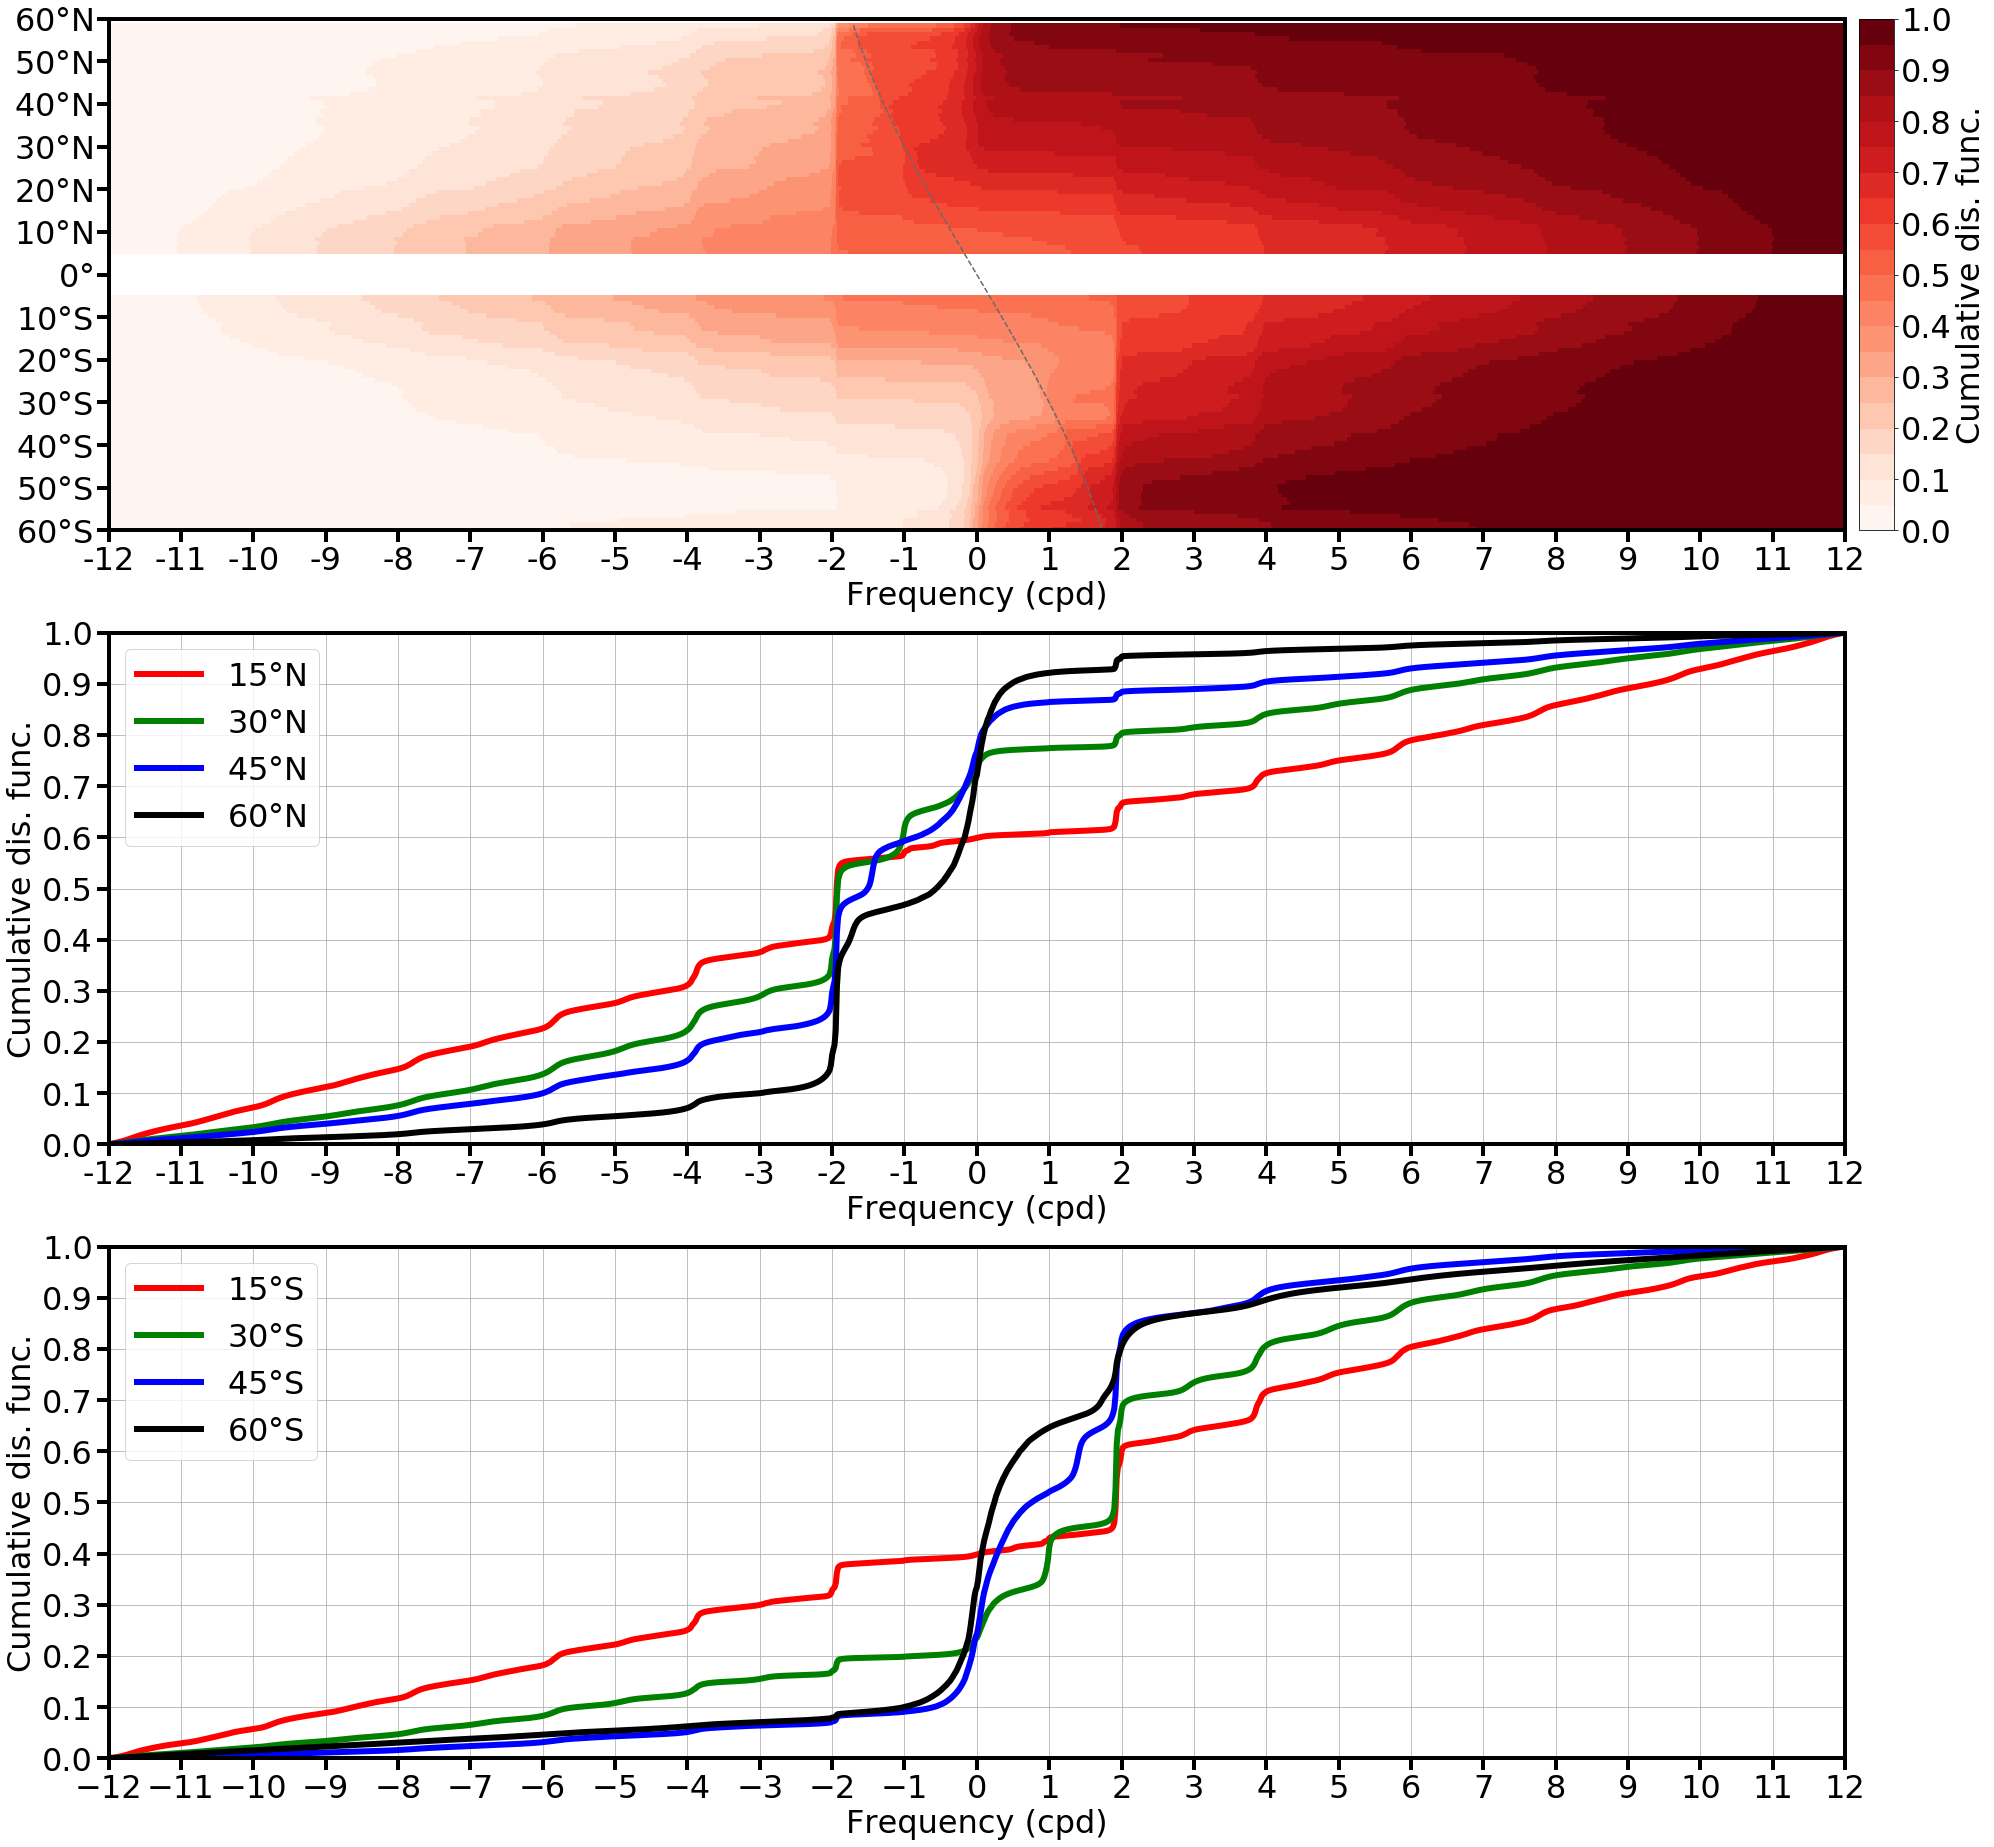

In [15]:
equator = 5
font_size = 32
linewidth = 6

fig, (ax2, ax3, ax4)  = plt.subplots(3,1,sharex=True,figsize=(32, 32))

    
ax2 = plt.subplot(311)
im2=(E_ageo_zav_cumsum.where(np.abs(E_ageo_zav.latitude)>equator)/E_ageo_zav_sum).plot(vmin=0, vmax=1, x='freq_time', y='latitude',cmap=plt.cm.get_cmap('Reds', 20), add_colorbar = False)
divider2 = make_axes_locatable(ax2)
cax = divider2.append_axes("right", size="2%", pad=.2)
cbar = plt.colorbar(im2,  cax=cax, orientation='vertical', ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Cumulative dis. func.', fontsize=font_size)
ax2.set_xlim(-12., 12.)
ax2.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax2.set_xticklabels(['-12','-11','-10','-9','-8','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5','6','7','8','9','10','11','12'])
ax2.set_ylim(-60., 60.)
ax2.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax2.set_yticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax2.tick_params(direction='out', length=6, width=2)
ax2.tick_params(labelsize=font_size)
ax2.set_ylabel('',fontsize=font_size)
ax2.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax2.plot(-f*86400./2./np.pi,f.latitude,'--',color='dimgrey')
ax2.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(4)

ax3 = plt.subplot(312)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="2%", pad=.2)
cax3.remove()
labels = ['$0\degree$', '$15\degree$N', '$30\degree$N', '$45\degree$N', '$60\degree$N']
ratio.sel(latitude=15, method='nearest').plot(ax=ax3,color='red', linewidth=linewidth, label=labels[1])
ratio.sel(latitude=30, method='nearest').plot(ax=ax3,color='green', linewidth=linewidth, label=labels[2])
ratio.sel(latitude=45, method='nearest').plot(ax=ax3,color='blue', linewidth=linewidth, label=labels[3])
ratio.sel(latitude=60, method='nearest').plot(ax=ax3,color='black', linewidth=linewidth, label=labels[4])
ax3.grid()
ax3.set_ylim([0,1])
ax3.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax3.tick_params(direction='out', length=6, width=2)
ax3.tick_params(labelsize=font_size)
ax3.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax3.set_ylabel('Cumulative dis. func.',fontsize=font_size)
ax3.set_xlim(-12., 12.)
ax3.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax3.set_xticklabels(['-12','-11','-10','-9','-8','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5','6','7','8','9','10','11','12'])
ax3.set_title('',fontsize=40)
ax3.legend()
ax3.legend(prop={'size': font_size })
ax3.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(4)

ax4 = plt.subplot(313)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="2%", pad=.2)
cax4.remove()
labels = ['$0\degree$', '$15\degree$S', '$30\degree$S', '$45\degree$S', '$60\degree$S']
ratio.sel(latitude=-15, method='nearest').plot(ax=ax4,color='red', linewidth=linewidth, label=labels[1])
ratio.sel(latitude=-30, method='nearest').plot(ax=ax4,color='green', linewidth=linewidth, label=labels[2])
ratio.sel(latitude=-45, method='nearest').plot(ax=ax4,color='blue', linewidth=linewidth, label=labels[3])
ratio.sel(latitude=-60, method='nearest').plot(ax=ax4,color='black', linewidth=linewidth, label=labels[4])
ax4.grid()
ax4.set_ylim([0,1])
ax4.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax4.tick_params(direction='out', length=6, width=2)
ax4.tick_params(labelsize=font_size)
ax4.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax4.set_ylabel('Cumulative dis. func.',fontsize=font_size)
ax4.set_xlim(-12., 12.)
ax4.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax3.set_xticklabels(['-12','-11','-10','-9','-8','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5','6','7','8','9','10','11','12'])
ax4.set_title('',fontsize=40)
ax4.legend()
ax4.legend(prop={'size': font_size })
ax4.tick_params(direction='out', length=12, width=4)
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(4)
    
plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_spectra_cumulative_together_0118.png')

In [17]:
cluster.close()

RuntimeError: Command exited with non-zero exit code.
Exit code: 35
Command:
qdel 4764857
stdout:

stderr:
qdel: Job has finished

